# Online analytical processing (OLAP): Based on when, where and how the crime took place.

Code written by : Rohit Ramesh Kumashi (Student ID : 862324644)

In [1]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
import os

## Importing data and creating spark session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
df = spark.read.format("csv").option("header", "true").load("Crime_Data_from_2010_to_2019.csv")
new_col_names = ["DR_NO",
 "Date_Rptd",
 "DATE_OCC",
 "TIME_OCC",
 "AREA",
 "AREA_NAME",
 "Rpt_Dist_No",
 "Part_1-2",
 "Crm_Cd",
 "Crm_Cd_Desc",
 "Mocodes",
 "Vict_Age",
 "Vict_Sex",
 "Vict_Descent",
 "Premis_Cd",
 "Premis_Desc",
 "Weapon_Used_Cd",
 "Weapon_Desc",
 "Status",
 "Status_Desc",
 "Crm_Cd_1",
 "Crm_Cd_2",
 "Crm_Cd_3",
 "Crm_Cd_4",
 "LOCATION",
 "Cross_Street",
 "LAT",
 "LON"]                                                                                                                      

22/12/06 18:03:10 WARN Utils: Your hostname, Spoorthis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.6 instead (on interface en0)
22/12/06 18:03:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/06 18:03:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Cleaning

In [3]:
df = df.toDF(*new_col_names)

In [4]:
df = df.select(*[col_name for col_name in new_col_names if col_name not in ["DATE_OCC","TIME_OCC",'Date_Rptd']],
               to_timestamp(concat(substring(df.DATE_OCC,1,10),lit(" "),substring(df.TIME_OCC,1,2),lit(":"),substring(df.TIME_OCC,3,2)),'MM/dd/yyyy HH:mm').alias('date_time_of_incident'),
               to_timestamp(substring(df.Date_Rptd,1,10),'MM/dd/yyyy').alias('Date_Rptd'))

In [5]:
df = df.withColumn("Victim_Descent_Description", expr("CASE WHEN Vict_Descent = 'A' THEN 'Other Asian' " +
                                                            "WHEN Vict_Descent = 'B' THEN 'Black' " +
                                                            "WHEN Vict_Descent = 'C' THEN 'Chinese' " +
                                                            "WHEN Vict_Descent = 'D' THEN 'Cambodian' " +
                                                            "WHEN Vict_Descent = 'F' THEN 'Filipino' " +
                                                            "WHEN Vict_Descent = 'G' THEN 'Guamanian' " +
                                                            "WHEN Vict_Descent = 'H' THEN 'Hispanic/Latin/Mexican' " +
                                                            "WHEN Vict_Descent = 'I' THEN 'American Indian/Alaskan Native' " +
                                                            "WHEN Vict_Descent = 'J' THEN 'Japanese' " +
                                                            "WHEN Vict_Descent = 'K' THEN 'Korean' " +
                                                            "WHEN Vict_Descent = 'L' THEN 'Laotian' " +
                                                            "WHEN Vict_Descent = 'O' THEN 'Other' " +
                                                            "WHEN Vict_Descent = 'P' THEN 'Pacific Islander' " +
                                                            "WHEN Vict_Descent = 'S' THEN 'Samoan' " +
                                                            "WHEN Vict_Descent = 'U' THEN 'Hawaiian' " +
                                                            "WHEN Vict_Descent = 'V' THEN 'Vietnamese' " +
                                                            "WHEN Vict_Descent = 'W' THEN 'White' " +
                                                            "WHEN Vict_Descent = 'X' THEN 'Unknown' " +
                                                            "WHEN Vict_Descent = 'Z' THEN 'Asian Indian' END"))

In [6]:
df.createOrReplaceTempView("crime_incidents")

22/12/06 18:03:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
df.printSchema()

root
 |-- DR_NO: string (nullable = true)
 |-- AREA: string (nullable = true)
 |-- AREA_NAME: string (nullable = true)
 |-- Rpt_Dist_No: string (nullable = true)
 |-- Part_1-2: string (nullable = true)
 |-- Crm_Cd: string (nullable = true)
 |-- Crm_Cd_Desc: string (nullable = true)
 |-- Mocodes: string (nullable = true)
 |-- Vict_Age: string (nullable = true)
 |-- Vict_Sex: string (nullable = true)
 |-- Vict_Descent: string (nullable = true)
 |-- Premis_Cd: string (nullable = true)
 |-- Premis_Desc: string (nullable = true)
 |-- Weapon_Used_Cd: string (nullable = true)
 |-- Weapon_Desc: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Status_Desc: string (nullable = true)
 |-- Crm_Cd_1: string (nullable = true)
 |-- Crm_Cd_2: string (nullable = true)
 |-- Crm_Cd_3: string (nullable = true)
 |-- Crm_Cd_4: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- Cross_Street: string (nullable = true)
 |-- LAT: string (nullable = true)
 |-- LON: string (nul

### Crime incidents year over year

In [8]:
query = "SELECT \
            YEAR(date_time_of_incident) AS crime_year, \
            COUNT(DR_NO) AS num_crimes \
        FROM crime_incidents \
        GROUP BY YEAR(date_time_of_incident) \
        ORDER BY crime_year"
result_by_year = spark.sql(query)
result_by_year = result_by_year.toPandas()
result_by_year.head(20)

,crime_year,num_crimes
0,2010,209229
1,2011,200792
2,2012,201621
3,2013,192689
4,2014,195628
5,2015,215641
6,2016,225609
7,2017,231303
8,2018,229197
9,2019,218088


### Crime incidents by month 

In [9]:
query = "SELECT \
            DATE_FORMAT(date_time_of_incident,'MMMM') AS month_of_crime, \
            FIRST_VALUE(MONTH(date_time_of_incident)) AS month_num, \
            COUNT(DR_NO) AS num_crimes \
        FROM crime_incidents \
        GROUP BY month_of_crime \
        ORDER BY month_num"
result_by_month = spark.sql(query)
result_by_month = result_by_month.toPandas()
result_by_month.head(20)

,month_of_crime,month_num,num_crimes
0,January,1,183674
1,February,2,157723
2,March,3,177067
3,April,4,173083
4,May,5,180530
5,June,6,177475
6,July,7,183194
7,August,8,183305
8,September,9,175493
9,October,10,182478


### Crime incidents by period of the day

In [10]:
query = '''SELECT
                t.time_of_day,
                COUNT(t.DR_NO) AS num_crimes
            FROM ( 
                SELECT 
                    DR_NO, 
                    CASE 
                        WHEN HOUR(date_time_of_incident) BETWEEN 6 AND 11 THEN 'morning' 
                        WHEN HOUR(date_time_of_incident) BETWEEN 12 AND 17 THEN 'afternoon' 
                        WHEN HOUR(date_time_of_incident) BETWEEN 18 AND 20 THEN 'evening' 
                        ELSE 'night' 
                    END AS time_of_day 
                FROM crime_incidents
               ) AS t
            GROUP BY t.time_of_day
        '''
result_by_time_of_day = spark.sql(query)
result_by_time_of_day = result_by_time_of_day.toPandas()
result_by_time_of_day.head(20)

,time_of_day,num_crimes
0,afternoon,700727
1,night,614695
2,morning,436408
3,evening,367967


## Visualization

### Trend in crime by year, month and time of day

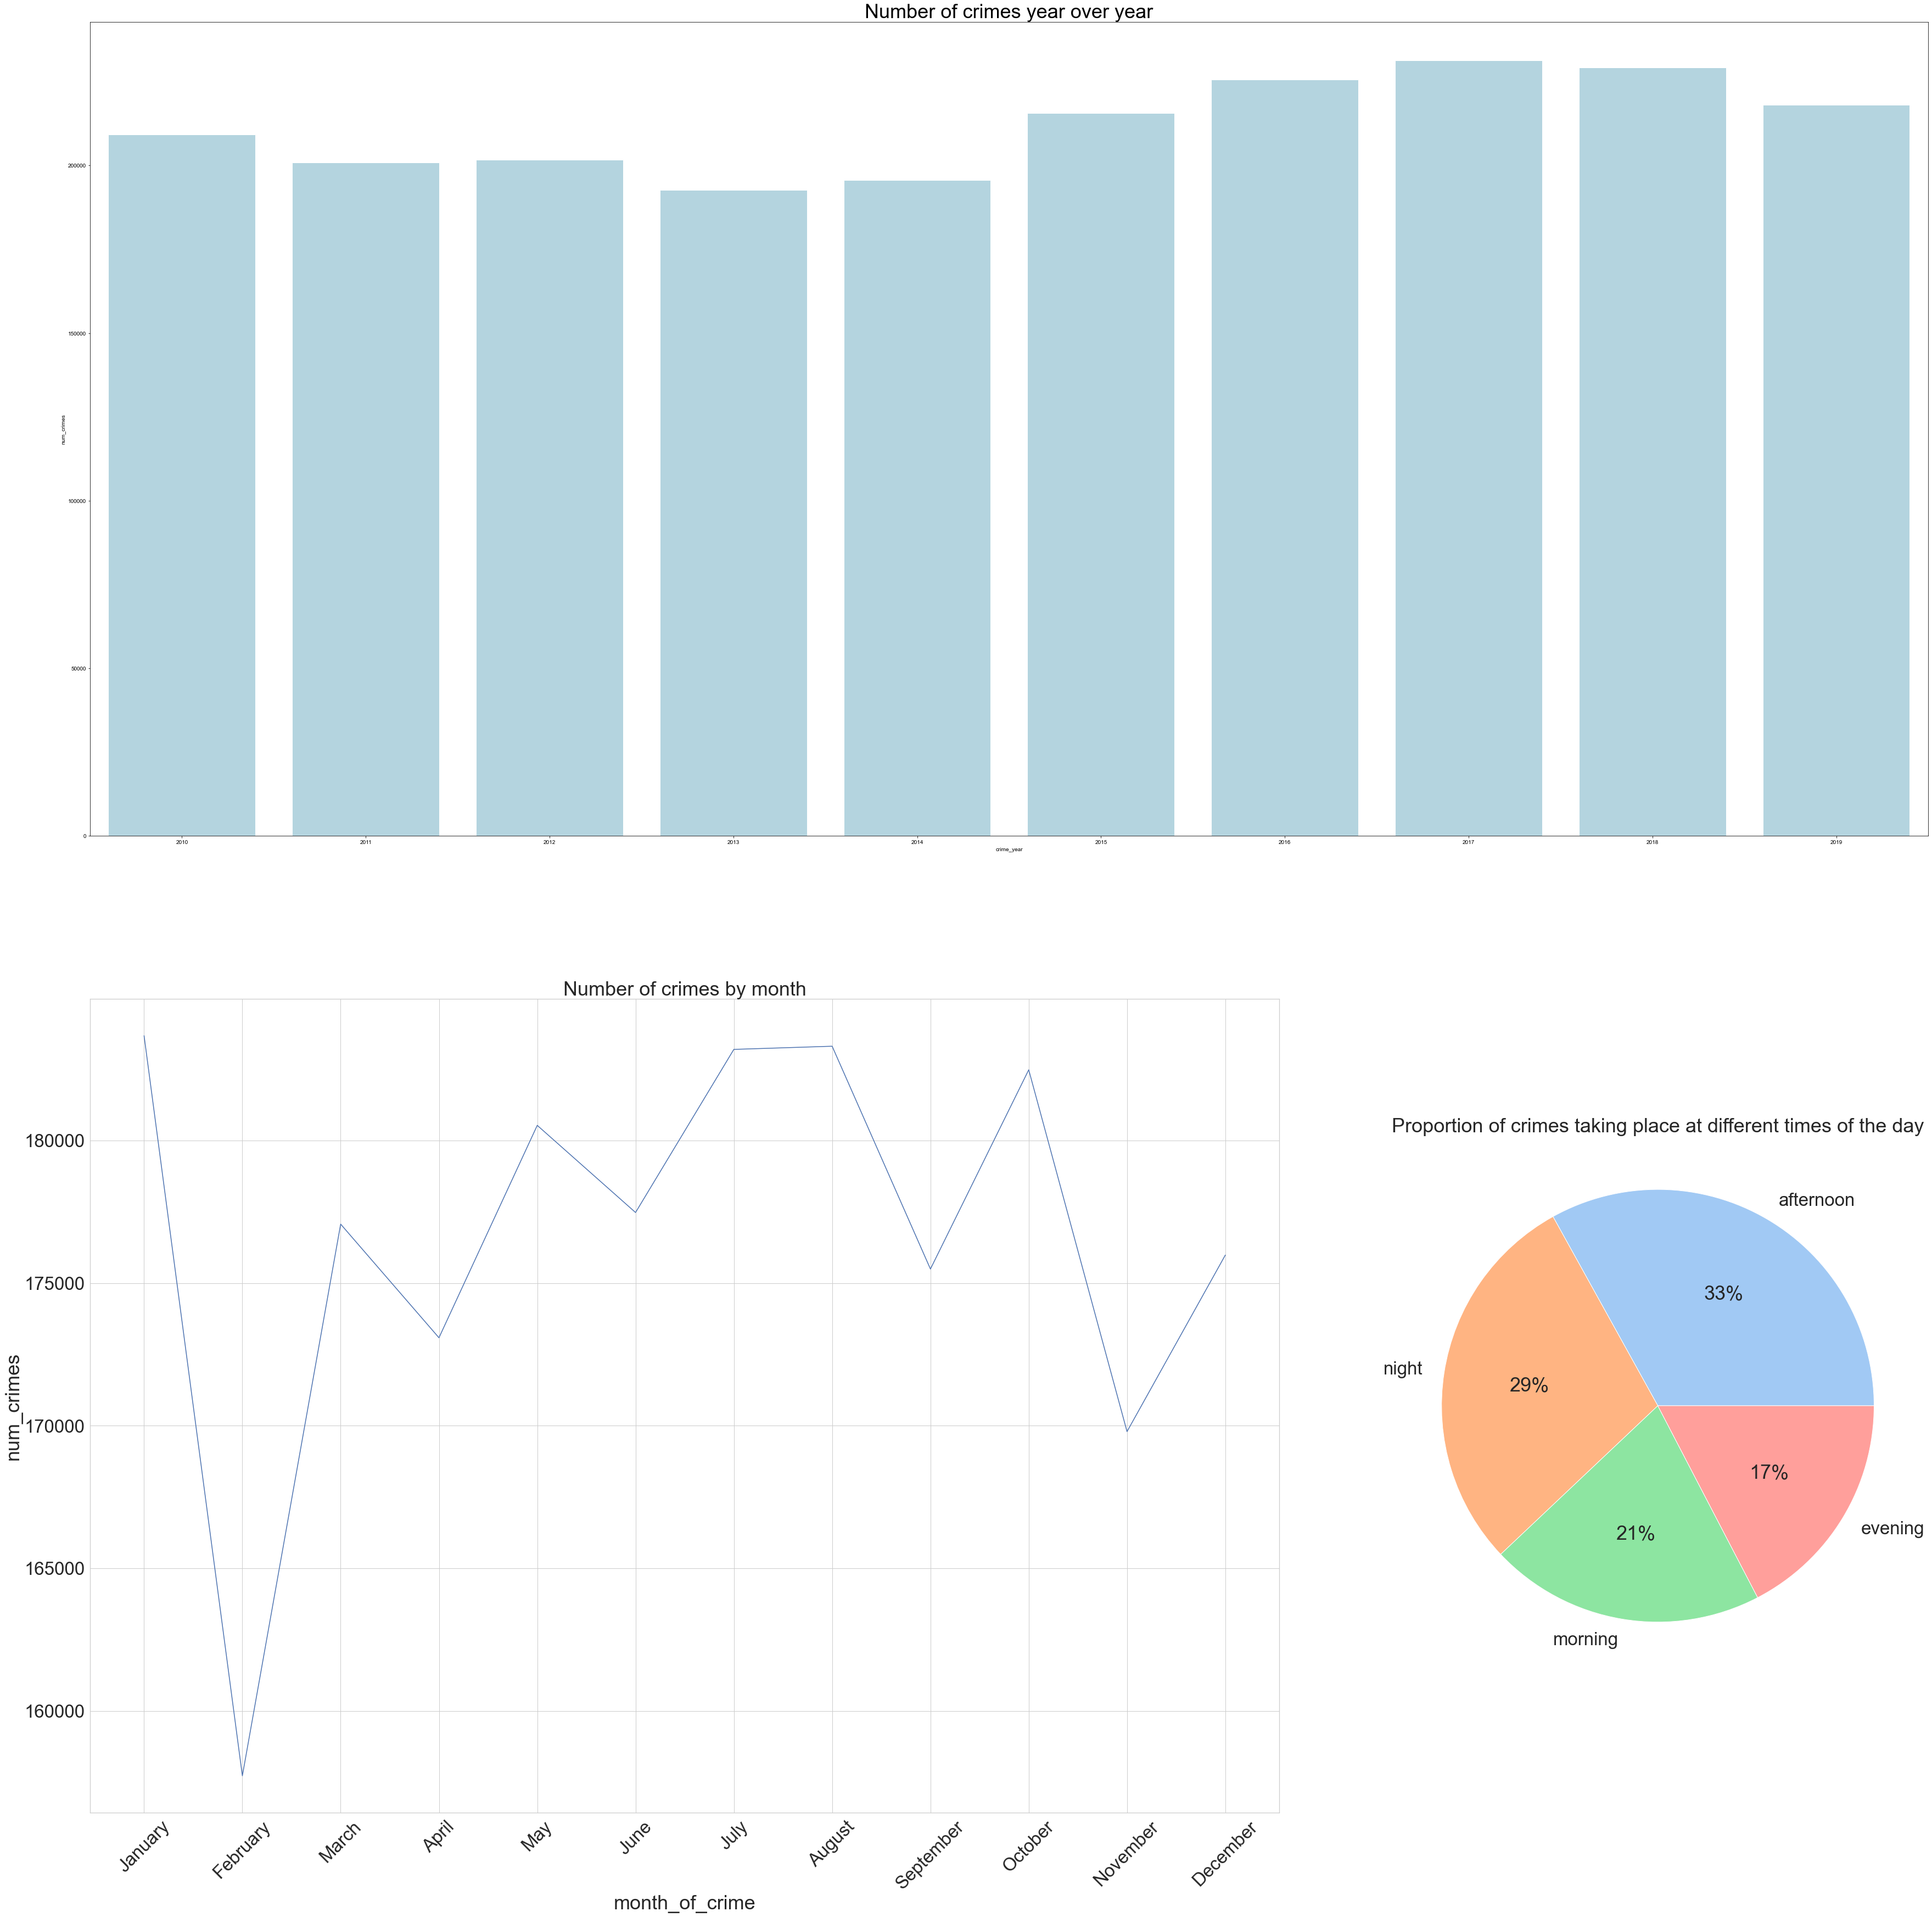

In [11]:
fig1 = plt.figure(figsize=(60,60))
plt.subplot(2, 3, (1,3))
sb.set(font_scale=3, style = "whitegrid")
sb.barplot(x= "crime_year", y = "num_crimes",data = result_by_year,color='lightblue')
plt.title("Number of crimes year over year")
plt.subplot(2, 3, (4,5))
sb.set(font_scale=3, style = "whitegrid")
sb.lineplot(x= "month_of_crime", y = "num_crimes",data = result_by_month)
plt.title("Number of crimes by month")
plt.xticks(rotation = 45)
plt.subplot(2,3,6)
colors = sb.color_palette('pastel')[0:5]
plt.pie(result_by_time_of_day.num_crimes, labels = result_by_time_of_day.time_of_day, colors = colors, autopct='%.0f%%')
plt.title("Proportion of crimes taking place at different times of the day")
plt.show()

The bar graph above(on the top), shows trend in crime by year. 
* The number of crime incidents has generally increased over the passage of time. The number of crime incidents reached its nadir in 2013, following which the crime incidents have obeyed the general trend of increasing numbers.
* More in-depth analysis is needed over smaller time frames to understand crimes and this is explained below.

The line chart on the bottom left depicts the historical monthly crime incidents
* The November to March period was lean in terms of average volume of criminal activities compared to the June to September period. 
* This can possibly be attributed to the fact that June to September months are climatically pleasant in comparison to other periods, leading to more interactions between victims and criminals

The pie chart (on the bottom right) shows that a third of the crimes take place in the afternoon, followed closely by those that occur at night times. Such times account for most crimes as these are usually when people either return from office, travel around, or do grocery shopping.

### Analyzing weapon choice by premise type

In [12]:
query = ''' 
        SELECT
            t.Premis_Desc,
            CONCAT_WS('',COLLECT_LIST(CASE WHEN t.weapon_usage_rank = 1 THEN t.Weapon_Desc ELSE NULL END)) AS most_used_weapon,
            CONCAT_WS('',COLLECT_LIST(CASE WHEN t.weapon_usage_rank = 2 THEN t.Weapon_Desc ELSE NULL END)) AS 2nd_most_used_weapon,
            CONCAT_WS('',COLLECT_LIST(CASE WHEN t.weapon_usage_rank = 3 THEN t.Weapon_Desc ELSE NULL END)) AS 3nd_most_used_weapon
        FROM (
            SELECT
                Premis_Desc,
                Weapon_Desc,
                weapon_usage_rank
            FROM (
                SELECT
                    Premis_Desc,
                    Weapon_Desc,
                    COUNT(DR_NO) AS num_crime_incidents,
                    DENSE_RANK() OVER (PARTITION BY Premis_Desc ORDER BY COUNT(DR_NO) DESC,Weapon_Desc) AS weapon_usage_rank
                FROM crime_incidents
                WHERE Weapon_Desc IS NOT NULL
                  AND Premis_Desc IS NOT NULL
                GROUP BY Premis_Desc,Weapon_Desc        
                 ) AS t
             WHERE weapon_usage_rank <= 3        
             ) AS t
        GROUP BY t.Premis_Desc
        '''
result_top_3_weapons_used_by_premise_type = spark.sql(query)
result_top_3_weapons_used_by_premise_type = result_top_3_weapons_used_by_premise_type.toPandas()
result_top_3_weapons_used_by_premise_type.head(20)

,Premis_Desc,most_used_weapon,2nd_most_used_weapon,3nd_most_used_weapon
0,7TH AND METRO CENTER (NOT LINE SPECIFIC),"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",UNKNOWN WEAPON/OTHER WEAPON,MACE/PEPPER SPRAY
1,ABANDONED BUILDING ABANDONED HOUSE,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",UNKNOWN WEAPON/OTHER WEAPON,VERBAL THREAT
2,ABATEMENT LOCATION,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",FIRE,UNKNOWN WEAPON/OTHER WEAPON
3,ABORTION CLINIC/ABORTION FACILITY*,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",CLUB/BAT,VERBAL THREAT
4,AIRCRAFT,UNKNOWN WEAPON/OTHER WEAPON,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",HAND GUN
5,ALLEY,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",HAND GUN,UNKNOWN WEAPON/OTHER WEAPON
6,AMTRAK TRAIN,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",REVOLVER,
7,AMUSEMENT PARK*,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",CLUB/BAT,FOLDING KNIFE
8,APARTMENT/CONDO COMMON LAUNDRY ROOM,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",UNKNOWN WEAPON/OTHER WEAPON,VERBAL THREAT
9,"ARCADE,GAME ROOM/VIDEO GAMES (EXAMPLE CHUCKIE ...","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",UNKNOWN WEAPON/OTHER WEAPON,BOMB THREAT


For all the premise types available in Los Angeles, the above text table shows the 3 most used weapons while perpetrating the crime. 

While devising this table for some premise types, the top rank did not have a weapon used which makes little sense for our question, and so we filtered those out. 
* This knowledge can guide police to use tactics specific to the premise and weapon used. 
  - For eg. ATM machines had handguns and simulated guns used most often by criminals to commit crime in such places. Police can then man such areas more frequently and devise tactics to reduce crimes there.

### Most Typical Crime by Victim Descent

In [13]:
query = ''' SELECT
                Victim_Descent_Description,
                Crm_Cd_Desc,
                num_crimes
            FROM (
                SELECT
                    Victim_Descent_Description,
                    Crm_Cd_Desc,
                    COUNT(DR_NO) AS num_crimes,
                    ROW_NUMBER() OVER w AS crime_type_freq
                FROM crime_incidents
                WHERE Victim_Descent_Description IS NOT NULL
                GROUP BY Victim_Descent_Description,Crm_Cd_Desc
                WINDOW w AS (PARTITION BY Victim_Descent_Description ORDER BY COUNT(DR_NO) DESC)
                ORDER BY Victim_Descent_Description,num_crimes DESC            
                ) AS t
            WHERE t.crime_type_freq = 1;
        '''
result_crime_by_descent = spark.sql(query)
result_crime_by_descent = result_crime_by_descent.toPandas()
result_crime_by_descent.head(20)

,Victim_Descent_Description,Crm_Cd_Desc,num_crimes
0,American Indian/Alaskan Native,THEFT PLAIN - PETTY ($950 & UNDER),165
1,Asian Indian,THEFT PLAIN - PETTY ($950 & UNDER),34
2,Black,BATTERY - SIMPLE ASSAULT,47253
3,Cambodian,THEFT PLAIN - PETTY ($950 & UNDER),4
4,Chinese,THEFT PLAIN - PETTY ($950 & UNDER),183
5,Filipino,BURGLARY FROM VEHICLE,365
6,Guamanian,BATTERY - SIMPLE ASSAULT,13
7,Hawaiian,THEFT OF IDENTITY,43
8,Hispanic/Latin/Mexican,BATTERY - SIMPLE ASSAULT,85870
9,Japanese,BURGLARY FROM VEHICLE,76


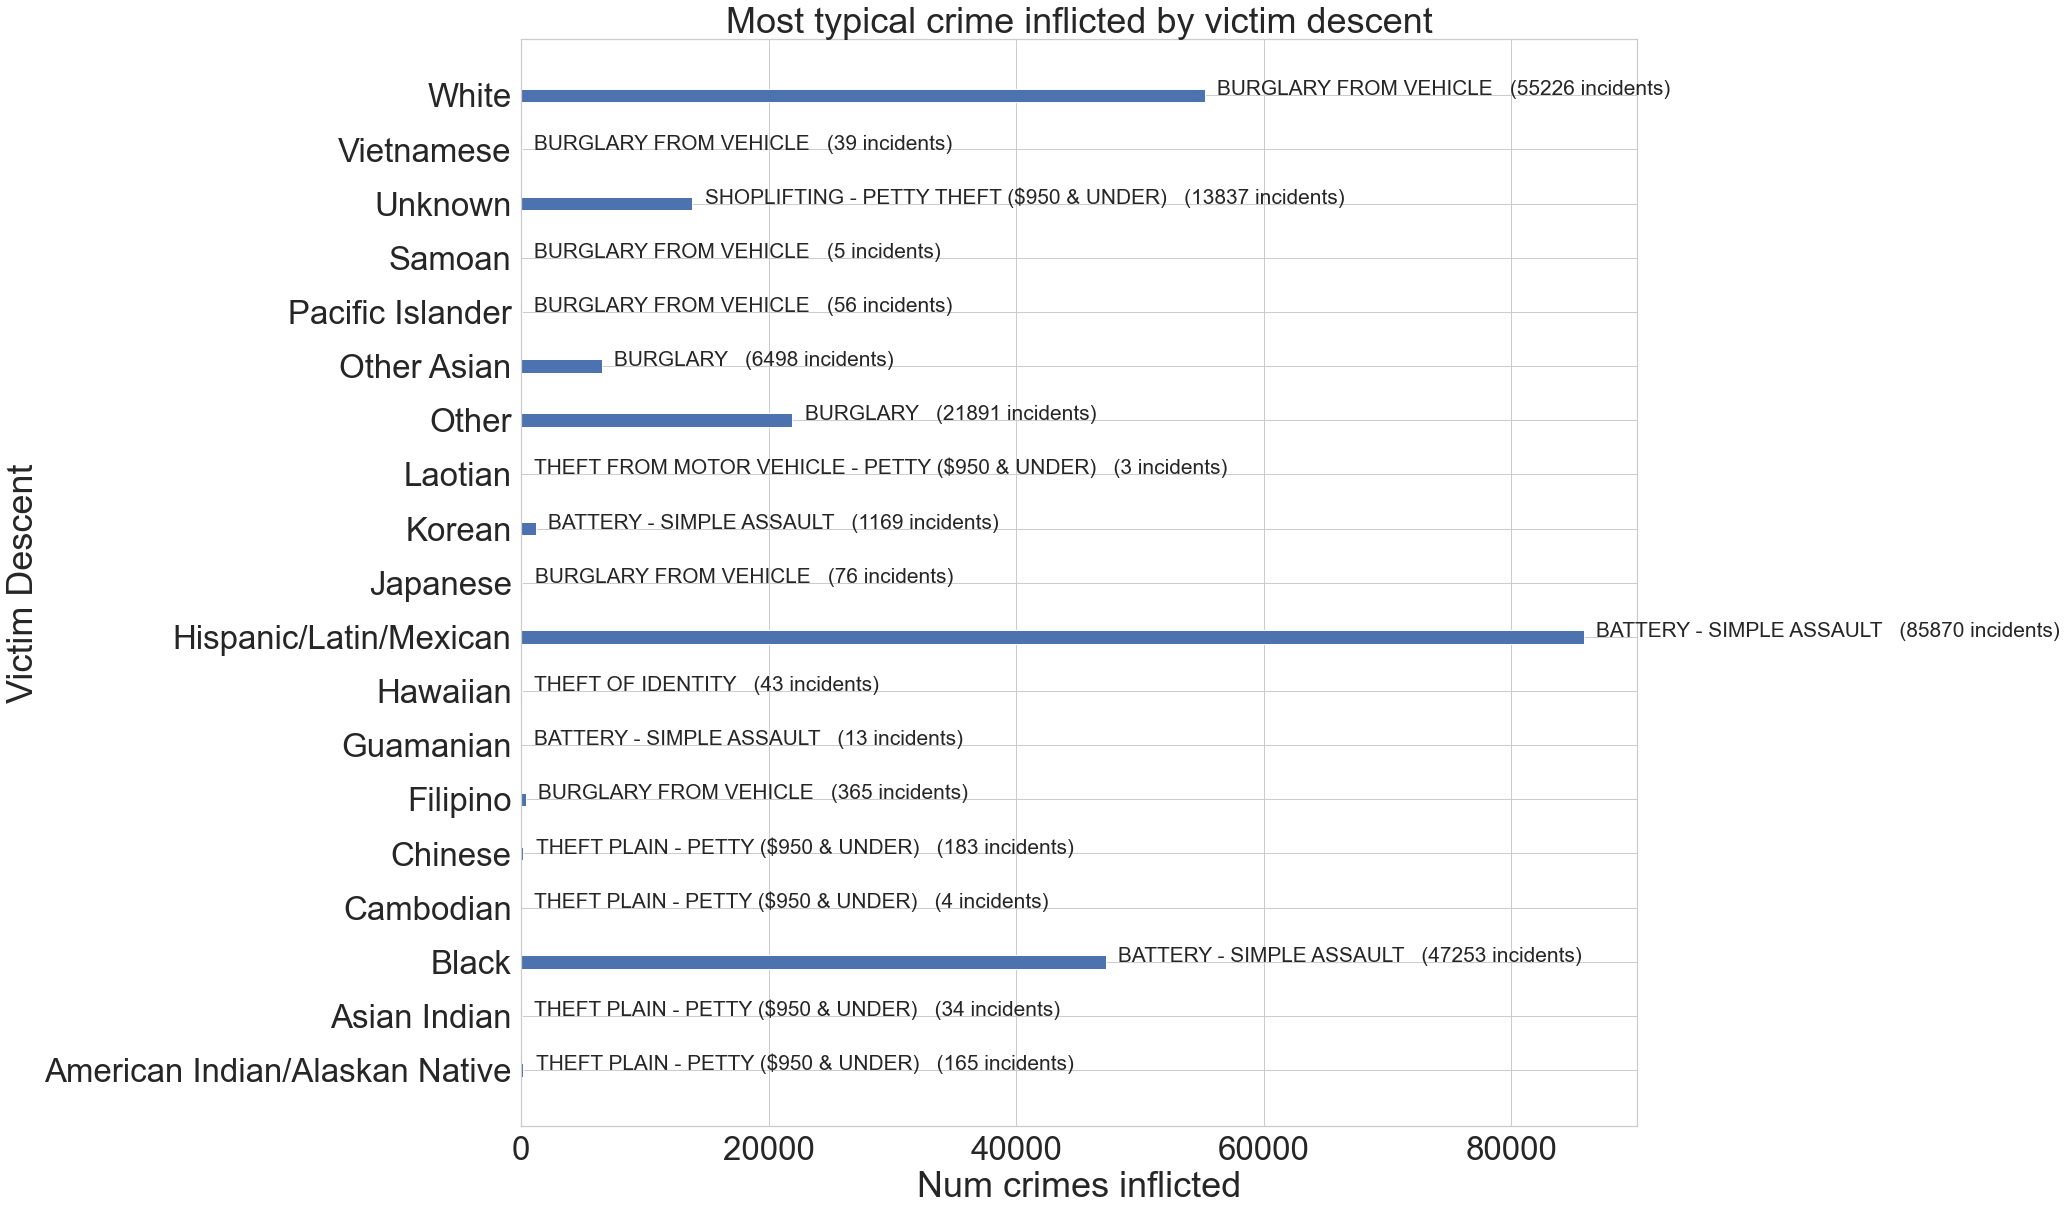

In [14]:
fig, ax = plt.subplots(figsize=(20,20))

bars = ax.barh(y=result_crime_by_descent.index*2,width=result_crime_by_descent['num_crimes'], height=0.5,tick_label=result_crime_by_descent['Victim_Descent_Description'])
ax.set_title('Most typical crime inflicted by victim descent')
ax.set_xlabel('Num crimes inflicted')
ax.set_ylabel('Victim Descent')
for i,crime_desc in enumerate(result_crime_by_descent['Crm_Cd_Desc']):
  ax.text(result_crime_by_descent['num_crimes'][i] + 1000,2*i,crime_desc+"   ({} incidents)".format(result_crime_by_descent['num_crimes'][i]),size='xx-small')

plt.show()

The bar plot on top shows the type of crime victims of varying demographics endure. People from the Black and Hispanic/Mexican community are often the target of crimes that involve battery and physical assault.

This knowledge can help the police to launch directed community programs that can help various demographics to be safe from such crimes.